In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


# **1- Importing Required Libraries**

In [2]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, models, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

# **2- Create Data Loader**

In [3]:
train_csv = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")
test_csv = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_test.csv")

In [4]:
class FashionDataset(Dataset):
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.label = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.image = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.label[index]
        image = self.image[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.label)

In [5]:
BATCH_SIZE = 32

# Transform data into Tensor that has a range from 0 to 1
train = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

# data loader
train_dataloader = DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_dataloader = DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

print("Training data size:", len(train_dataloader) * BATCH_SIZE)
print("Test data size:", len(test_dataloader) * BATCH_SIZE)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Training data size: 60000
Test data size: 10016
Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) torch.int64


# **3- Data Visualisation**

In [6]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

labels:  Pullover, Ankle Boot, Shirt, T-shirt/Top, Dress, Coat, Coat, Sandal, Coat, Bag, 

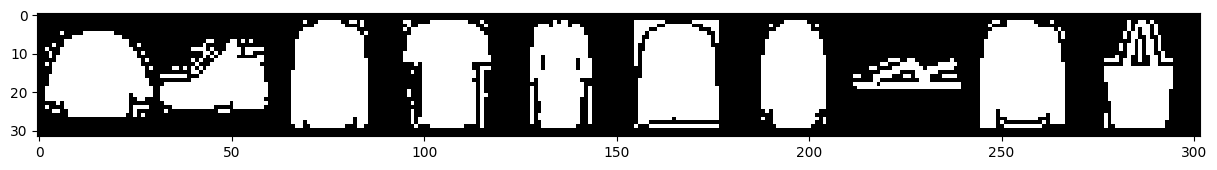

In [7]:
demo_loader = DataLoader(train, batch_size=10)
batch = next(iter(demo_loader))
images, labels = batch

grid = make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

# **4- Define Neural Network Model**

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="3px" color="white">
<hr style="color: red;">
We first determine the best device for performing training with cpu as the default device.

We then define the AI model as a neural network with 3 layers: an input layer, a hidden layer, and an output layer. Between the layers, we use a ReLU activation function.

Since the input images are 1x28x28 tensors, we need to flatten the input tensors into a 784 element tensor using the Flatten module before passing the input into our neural network. 
<hr style="color: red;">
</font>
</div>

In [8]:
# Get device for training.
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() # Apple Silicon GPU
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [9]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, image_tensor):
        image_tensor = self.flatten(image_tensor)
        logits = self.linear_relu_stack(image_tensor)
        return logits

input_size = 28*28
hidden_size = 512
num_classes = 10

model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# **5- Training loop**

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="3px" color="white">
<hr style="color: red;">
 We implement a training function to use with the train_dataloader to train our model. Each iteration over the dataloader returns a batch_size image data tensor along with the expected output. After moving the tensors to the device, we call the forward pass of our model, compute the prediction error using the expected output and then call the backwards pass to compute the gradients and apply them to the model parameters. 
<hr style="color: red;">
</font>
</div>

In [10]:
# Define our learning rate, loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Let's define our training function 
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch_num, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass to compute prediction
        pred = model(X)
        # Compute prediction error using loss function
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad() # zero any previous gradient calculations
        loss.backward() # calculate gradient
        optimizer.step() # update model parameters
        
        if batch_num > 0 and batch_num % 100 == 0:
            loss, current = loss.item(), batch_num * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# **6- Test Loop**

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="3px" color="white">
<hr style="color: red;">
The test methods evaluates the model's predictive performance using the test_dataloader. During testing, we don't require gradient computation, so we set the model in evaluate mode.
<hr style="color: red;">
</font>
</div>

In [11]:
# Our test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# **7- Train the Neural Network Model**

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="3px" color="white">
<hr style="color: red;">
Now that we have defined methods to train our model and test the trained model's predictive behavior, lets train the model for 5 epochs over the dataset.
<hr style="color: red;">
</font>
</div>

In [12]:
# Let's run training
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.979153  [ 3200/60000]
loss: 0.503783  [ 6400/60000]
loss: 0.536911  [ 9600/60000]
loss: 1.057619  [12800/60000]
loss: 0.365578  [16000/60000]
loss: 0.386335  [19200/60000]
loss: 0.628439  [22400/60000]
loss: 0.306261  [25600/60000]
loss: 0.837170  [28800/60000]
loss: 0.718296  [32000/60000]
loss: 0.501915  [35200/60000]
loss: 0.425205  [38400/60000]
loss: 0.415609  [41600/60000]
loss: 0.315044  [44800/60000]
loss: 0.785460  [48000/60000]
loss: 0.319825  [51200/60000]
loss: 0.312713  [54400/60000]
loss: 0.573245  [57600/60000]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.428401 

Epoch 2
-------------------------------
loss: 0.475656  [ 3200/60000]
loss: 0.416803  [ 6400/60000]
loss: 0.307328  [ 9600/60000]
loss: 0.784800  [12800/60000]
loss: 0.215825  [16000/60000]
loss: 0.249738  [19200/60000]
loss: 0.428722  [22400/60000]
loss: 0.284105  [25600/60000]
loss: 0.476458  [28800/60000]
loss: 0.653090  [32000/60000]
loss: 0.467517  [35200/60000

# **8- Define Convolutional Neural Networks Model**

In [13]:
class ConvolutionalNeuralNetworks(nn.Module):
    def __init__(self, num_classes):
        super(ConvolutionalNeuralNetworks, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(7 * 7 * 64, num_classes),
        )

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.reshape(out.size(0), -1)
        out = self.dense_layers(out)
        return out

# **9- Training loop**

In [14]:
# Let's define our training function 
def train():
    Train_epoch = 5
    model = ConvolutionalNeuralNetworks(num_classes).to(device)
    # Define our learning rate, loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
    
    for epoch in range(1, Train_epoch + 1):
        for batch_num, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            # Forward pass to compute prediction
            pred = model(X)
            # Compute prediction error using loss function
            loss = loss_fn(pred, y)

            # Backward pass
            optimizer.zero_grad() # zero any previous gradient calculations
            loss.backward() # calculate gradient
            optimizer.step() # update model parameters

            if batch_num % 1000 == 0:
                print('Loss :{:.4f} Epoch[{}/{}]'.format(loss.item(), epoch, Train_epoch))
    return model

# **10- Test Loop**

In [15]:
# Our test function
def test(model):
    with torch.no_grad():
        correct = 0
        total = 0
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            pred = torch.argmax(pred,dim=1)
            total += y.size(0)
            correct += (pred == y).sum().item()
        print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# **11- Train the CNN Model**

In [16]:
if __name__ == '__main__':
    model = train()
    test(model)

Loss :2.5026 Epoch[1/5]
Loss :0.5341 Epoch[1/5]
Loss :0.2803 Epoch[2/5]
Loss :0.4026 Epoch[2/5]
Loss :0.1582 Epoch[3/5]
Loss :0.3913 Epoch[3/5]
Loss :0.1775 Epoch[4/5]
Loss :0.2756 Epoch[4/5]
Loss :0.1788 Epoch[5/5]
Loss :0.2523 Epoch[5/5]
Test Accuracy of the model on the test images: 89.75 %


<div style="background-color: red; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
If my notebook was useful for you, please give me a upvote. Thank you for your support ❤️
    <hr style="color: green;"></font>
    <font size="5px">
         <a href="https://github.com/omid-sakaki-ghazvini">Github</a>
        <br/>
        <a href="http://linkedin.com/in/omid-sakaki-ghazvini-378687217">linkedin</a> 
    </font>
</div>